Using device: cuda

Evaluating pretrained model...

Training model from scratch...
Epoch 1/20
Train Loss: 0.0000
Val Loss: 0.0000


/home/jovyan/.conda/envs/earthquake-download/lib/python3.11/site-packages/seisbench/models/base.py:489: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.l

Epoch 2/20
Train Loss: 0.0000
Val Loss: 0.0000
Epoch 3/20
Train Loss: 0.0000
Val Loss: 0.0000
Epoch 4/20
Train Loss: 0.0000
Val Loss: 0.0000
Epoch 5/20
Train Loss: 0.0000
Val Loss: 0.0000
Epoch 6/20
Train Loss: 0.0000
Val Loss: 0.0000
Epoch 7/20
Train Loss: 0.0000
Val Loss: 0.0000
Epoch 8/20
Train Loss: 0.0000
Val Loss: 0.0000
Epoch 9/20
Train Loss: 0.0000
Val Loss: 0.0000
Epoch 10/20
Train Loss: 0.0000
Val Loss: 0.0000
Epoch 11/20
Train Loss: 0.0000
Val Loss: 0.0000
Epoch 12/20
Train Loss: 0.0000
Val Loss: 0.0000
Epoch 13/20
Train Loss: 0.0000
Val Loss: 0.0000
Epoch 14/20
Train Loss: 0.0000
Val Loss: 0.0000
Epoch 15/20
Train Loss: 0.0000
Val Loss: 0.0000
Epoch 16/20
Train Loss: 0.0000
Val Loss: 0.0000
Epoch 17/20
Train Loss: 0.0000
Val Loss: 0.0000
Epoch 18/20
Train Loss: 0.0000
Val Loss: 0.0000
Epoch 19/20
Train Loss: 0.0000
Val Loss: 0.0000
Epoch 20/20
Train Loss: 0.0000
Val Loss: 0.0000

Fine-tuning pretrained model...
Epoch 1/10
Train Loss: 0.0001
Val Loss: 0.0001
Epoch 2/10
Train

/home/jovyan/.conda/envs/earthquake-download/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jovyan/.conda/envs/earthquake-download/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


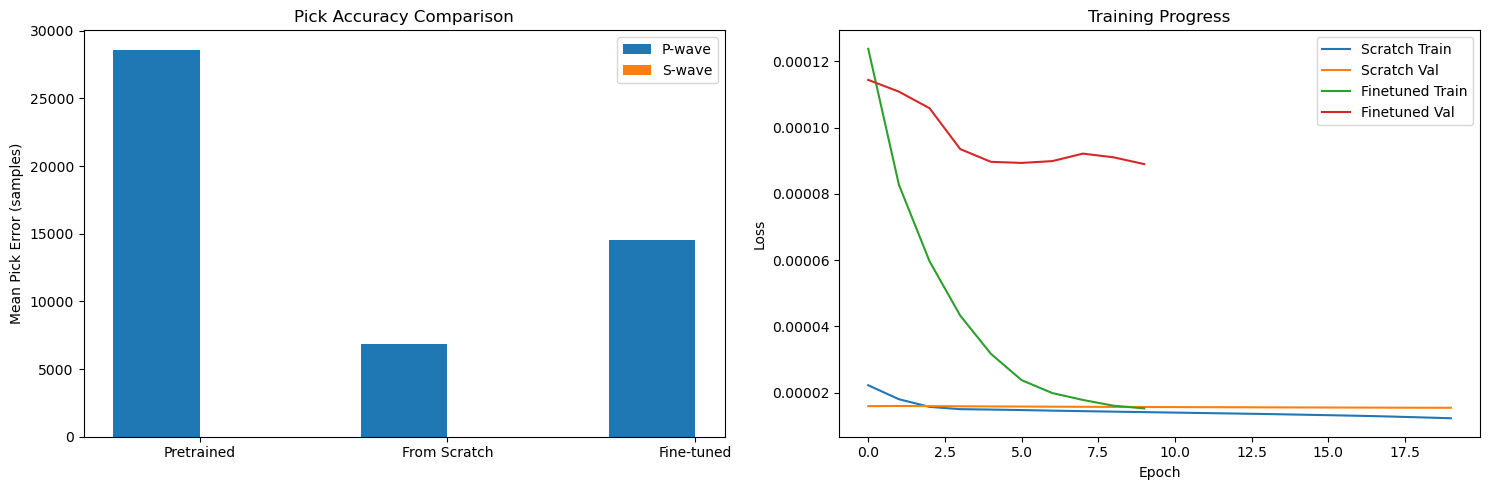

In [5]:
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from obspy import UTCDateTime
import os
import matplotlib.pyplot as plt

class IndonesiaDataset(Dataset):
    """Custom Dataset untuk data gempa Indonesia"""
    def __init__(self, base_dir="seismic_data"):
        self.base_dir = base_dir
        self.picks_df = pd.read_csv(os.path.join(base_dir, "all_picks.csv"))
        self.picks_df['pick_time'] = pd.to_datetime(self.picks_df['pick_time'])
        self.picks_df['event_time'] = pd.to_datetime(self.picks_df['event_time'])
        
        # Load semua waveform dan label
        self.data = []
        station_dirs = [d for d in os.listdir(base_dir) 
                       if os.path.isdir(os.path.join(base_dir, d)) and 
                       d != '.ipynb_checkpoints']  # Ignore checkpoints folder
        
        for station in station_dirs:
            try:
                waveform_path = os.path.join(base_dir, station, 'waveforms.npy')
                labels_path = os.path.join(base_dir, station, 'labels.npy')
                
                if not os.path.exists(waveform_path) or not os.path.exists(labels_path):
                    continue
                    
                waveforms = np.load(waveform_path)
                labels = np.load(labels_path)
                station_picks = self.picks_df[self.picks_df["station"] == station]
                
                for i in range(len(waveforms)):
                    if i < len(station_picks):
                        self.data.append({
                            "X": torch.FloatTensor(waveforms[i]),  # Convert to tensor here
                            "y": torch.FloatTensor(labels[i]),     # Convert to tensor here
                            "station": station,
                            "event_time": station_picks.iloc[i]['event_time']
                        })
            except Exception as e:
                print(f"Error loading station {station}: {str(e)}")
                
        if len(self.data) == 0:
            raise RuntimeError("No valid data found in the dataset")
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

def custom_collate(batch):
    """Custom collate function untuk DataLoader"""
    return {
        'X': torch.stack([item['X'] for item in batch]),
        'y': torch.stack([item['y'] for item in batch]),
        'station': [item['station'] for item in batch],
        'event_time': [item['event_time'] for item in batch]
    }


def prepare_experiment():
    """Persiapan untuk eksperimen"""
    # Load dataset
    dataset = IndonesiaDataset()
    
    # Split data
    total_size = len(dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )
    
    return train_dataset, val_dataset, test_dataset

def train_model(model, train_loader, val_loader, epochs=10, device="cuda"):
    """Training loop"""
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    def loss_fn(y_pred, y_true, eps=1e-5):
        # Hanya ambil output P dan S dari model (abaikan N)
        y_pred = y_pred[:, :2, :]
        h = y_true * torch.log(y_pred + eps)
        h = h.mean(-1).sum(-1)
        return -h.mean()
    
    train_losses = []
    val_losses = []
    
    model = model.to(device)
    
    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            X = batch["X"].float().to(device)
            y = batch["y"].float().to(device)
            
            pred = model(X)
            loss = loss_fn(pred, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        train_losses.append(epoch_loss / len(train_loader))
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                X = batch["X"].float().to(device)
                y = batch["y"].float().to(device)
                
                pred = model(X)
                loss = loss_fn(pred, y)
                val_loss += loss.item()
                
        val_losses.append(val_loss / len(val_loader))
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f}")
        print(f"Val Loss: {val_losses[-1]:.4f}")
    
    return train_losses, val_losses

def evaluate_model(model, test_loader, device="cuda"):
    """Evaluasi model"""
    model = model.to(device)
    model.eval()
    picks_accuracy = {"P": [], "S": []}
    
    with torch.no_grad():
        for batch in test_loader:
            X = batch["X"].float().to(device)
            y = batch["y"].float().to(device)
            
            pred = model(X)
            # Hanya gunakan output P dan S
            pred = pred[:, :2, :]
            
            # Evaluasi picks
            for i in range(len(X)):
                true_p = np.where(y[i, 0].cpu().numpy() == 1)[0]
                true_s = np.where(y[i, 1].cpu().numpy() == 1)[0]
                
                pred_p = np.where(pred[i, 0].cpu().numpy() > 0.5)[0]
                pred_s = np.where(pred[i, 1].cpu().numpy() > 0.5)[0]
                
                if len(true_p) > 0 and len(pred_p) > 0:
                    picks_accuracy["P"].append(abs(true_p[0] - pred_p[0]))
                if len(true_s) > 0 and len(pred_s) > 0:
                    picks_accuracy["S"].append(abs(true_s[0] - pred_s[0]))
    
    return picks_accuracy

def run_experiments():
    """Menjalankan semua eksperimen"""
    try:
        train_dataset, val_dataset, test_dataset = prepare_experiment()
        
        # DataLoader dengan custom collate function
        batch_size = 32
        train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                                shuffle=True, collate_fn=custom_collate)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                              collate_fn=custom_collate)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                               collate_fn=custom_collate)
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {device}")
        
        results = {}
        
        # 1. PhaseNet pretrained tanpa fine-tuning
        print("\nEvaluating pretrained model...")
        model_pretrained = sbm.PhaseNet.from_pretrained("geofon")
        model_pretrained = model_pretrained.to(device)  # Pindahkan model ke GPU
        pretrained_accuracy = evaluate_model(model_pretrained, test_loader, device)
        results['pretrained'] = pretrained_accuracy
        
        # 2. PhaseNet dari awal dengan data Indonesia
        print("\nTraining model from scratch...")
        model_scratch = sbm.PhaseNet(phases="PSN")
        model_scratch = model_scratch.to(device)  # Pindahkan model ke GPU
        train_losses_scratch, val_losses_scratch = train_model(
            model_scratch, train_loader, val_loader, epochs=20, device=device
        )
        scratch_accuracy = evaluate_model(model_scratch, test_loader, device)
        results['scratch'] = scratch_accuracy
        results['losses'] = {'scratch': (train_losses_scratch, val_losses_scratch)}
        
        # 3. PhaseNet pretrained dengan fine-tuning
        print("\nFine-tuning pretrained model...")
        model_finetuned = sbm.PhaseNet.from_pretrained("geofon")
        model_finetuned = model_finetuned.to(device)  # Pindahkan model ke GPU
        train_losses_finetuned, val_losses_finetuned = train_model(
            model_finetuned, train_loader, val_loader, epochs=10, device=device
        )
        finetuned_accuracy = evaluate_model(model_finetuned, test_loader, device)
        results['finetuned'] = finetuned_accuracy
        results['losses']['finetuned'] = (train_losses_finetuned, val_losses_finetuned)
        
        return results
        
    except Exception as e:
        print(f"Error in experiments: {str(e)}")
        raise

# Jalankan eksperimen
results = run_experiments()

# Plot hasil
def plot_results(results):
    """Plot perbandingan hasil"""
    plt.figure(figsize=(15, 5))
    
    # Plot accuracy
    plt.subplot(121)
    models = ['Pretrained', 'From Scratch', 'Fine-tuned']
    p_acc = [np.mean(results['pretrained']['P']), 
             np.mean(results['scratch']['P']),
             np.mean(results['finetuned']['P'])]
    s_acc = [np.mean(results['pretrained']['S']), 
             np.mean(results['scratch']['S']),
             np.mean(results['finetuned']['S'])]
    
    x = np.arange(len(models))
    width = 0.35
    
    plt.bar(x - width/2, p_acc, width, label='P-wave')
    plt.bar(x + width/2, s_acc, width, label='S-wave')
    plt.ylabel('Mean Pick Error (samples)')
    plt.title('Pick Accuracy Comparison')
    plt.xticks(x, models)
    plt.legend()
    
    # Plot losses
    plt.subplot(122)
    plt.plot(results['losses']['scratch'][0], label='Scratch Train')
    plt.plot(results['losses']['scratch'][1], label='Scratch Val')
    plt.plot(results['losses']['finetuned'][0], label='Finetuned Train')
    plt.plot(results['losses']['finetuned'][1], label='Finetuned Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_results(results)

In [7]:
def create_comparison_table(model, test_loader, device="cuda", threshold=0.5):
    """
    Membuat tabel perbandingan antara prediksi dan ground truth
    """
    model = model.to(device)
    model.eval()
    
    comparison_data = []
    
    with torch.no_grad():
        for batch in test_loader:
            X = batch["X"].float().to(device)
            y = batch["y"].float().to(device)
            stations = batch["station"]
            event_times = batch["event_time"]
            
            pred = model(X)
            pred = pred[:, :2, :]  # Ambil hanya P dan S
            
            # Konversi ke probabilitas dengan softmax
            pred = torch.softmax(pred, dim=1)
            
            # Evaluasi setiap contoh dalam batch
            for i in range(len(X)):
                # Ground truth
                true_p = np.where(y[i, 0].cpu().numpy() == 1)[0]
                true_s = np.where(y[i, 1].cpu().numpy() == 1)[0]
                
                # Prediksi (ambil puncak probabilitas tertinggi)
                p_prob = pred[i, 0].cpu().numpy()
                s_prob = pred[i, 1].cpu().numpy()
                
                # Cari puncak probabilitas yang melebihi threshold
                from scipy.signal import find_peaks
                p_peaks, _ = find_peaks(p_prob, height=threshold)
                s_peaks, _ = find_peaks(s_prob, height=threshold)
                
                # Pilih puncak dengan probabilitas tertinggi
                pred_p = p_peaks[np.argmax(p_prob[p_peaks])] if len(p_peaks) > 0 else None
                pred_s = s_peaks[np.argmax(s_prob[s_peaks])] if len(s_peaks) > 0 else None
                
                # Hitung error dalam detik (sampling rate 100 Hz)
                p_error = None
                s_error = None
                
                if len(true_p) > 0:
                    if pred_p is not None:
                        p_error = abs(true_p[0] - pred_p) / 100
                    true_p = true_p[0]
                else:
                    true_p = None
                    
                if len(true_s) > 0:
                    if pred_s is not None:
                        s_error = abs(true_s[0] - pred_s) / 100
                    true_s = true_s[0]
                else:
                    true_s = None
                
                # Tambahkan ke data perbandingan
                comparison_data.append({
                    'station': stations[i],
                    'event_time': event_times[i],
                    'true_p_sample': true_p,
                    'pred_p_sample': pred_p,
                    'p_error_seconds': p_error,
                    'p_confidence': np.max(p_prob) if pred_p is not None else None,
                    'true_s_sample': true_s,
                    'pred_s_sample': pred_s,
                    's_error_seconds': s_error,
                    's_confidence': np.max(s_prob) if pred_s is not None else None
                })
    
    df = pd.DataFrame(comparison_data)
    
    # Format kolom waktu
    df['event_time'] = pd.to_datetime(df['event_time'])
    
    # Format numerik
    numeric_cols = ['p_error_seconds', 's_error_seconds', 'p_confidence', 's_confidence']
    for col in numeric_cols:
        df[col] = df[col].apply(lambda x: f"{x:.2f}" if pd.notnull(x) else None)
    
    return df

def export_comparison_tables():
    """
    Membuat dan mengekspor tabel perbandingan untuk setiap model
    """
    print("Membuat tabel perbandingan...")
    
    # Persiapkan data
    train_dataset, val_dataset, test_dataset = prepare_experiment()
    test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=custom_collate)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Dictionary untuk menyimpan hasil setiap model
    all_comparisons = {}
    
    # Evaluasi setiap model
    models = {
        'Pretrained': sbm.PhaseNet.from_pretrained("geofon"),
        'Scratch': sbm.PhaseNet(phases="PSN"),
        'Finetuned': sbm.PhaseNet.from_pretrained("geofon")
    }
    
    for name, model in models.items():
        print(f"\nEvaluasi model {name}...")
        model = model.to(device)
        
        # Buat tabel perbandingan
        comparison = create_comparison_table(model, test_loader, device, threshold=0.3)
        all_comparisons[name] = comparison
        
        # Export ke CSV
        filename = f'{name.lower()}_comparison.csv'
        comparison.to_csv(filename, index=False)
        print(f"Hasil disimpan ke {filename}")
        
        # Tampilkan statistik
        print("\nStatistik:")
        print(f"Total sampel: {len(comparison)}")
        print(f"P-wave detection rate: {(comparison['pred_p_sample'].notna().sum() / len(comparison)) * 100:.1f}%")
        print(f"S-wave detection rate: {(comparison['pred_s_sample'].notna().sum() / len(comparison)) * 100:.1f}%")
        print(f"Mean P-wave error: {pd.to_numeric(comparison['p_error_seconds'], errors='coerce').mean():.3f} seconds")
        print(f"Mean S-wave error: {pd.to_numeric(comparison['s_error_seconds'], errors='coerce').mean():.3f} seconds")
        
        # Tampilkan beberapa contoh
        print("\nContoh hasil:")
        print(comparison.head().to_string())

# Jalankan
export_comparison_tables()

Membuat tabel perbandingan...

Evaluasi model Pretrained...
Hasil disimpan ke pretrained_comparison.csv

Statistik:
Total sampel: 8
P-wave detection rate: 50.0%
S-wave detection rate: 50.0%
Mean P-wave error: 154.895 seconds
Mean S-wave error: nan seconds

Contoh hasil:
  station              event_time  true_p_sample  pred_p_sample p_error_seconds p_confidence true_s_sample  pred_s_sample s_error_seconds s_confidence
0    FAKI 2023-12-04 18:21:32.860          17903            NaN            None         None          None            NaN            None         None
1    BBJI 2023-12-24 06:00:54.660          20219          265.0          199.54         0.73          None        23568.0            None         0.73
2    BNDI 2023-12-19 12:48:34.420          13677          235.0          134.42         0.50          None          234.0            None         0.73
3    SANI 2023-12-26 03:31:38.410          20052            NaN            None         None          None            NaN    

/home/jovyan/.conda/envs/earthquake-download/lib/python3.11/site-packages/seisbench/models/base.py:489: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.l